### renewDataFirst
dataUpdater/udp
1. Breadth
2. Correlation

In [6]:
import pandas as pd
import numpy as np
import talib as ta
import os
import matplotlib.pyplot as plt
import warnings
import pymongo
from datetime import datetime, timedelta
import mplfinance as mpf
import scipy.stats as stats
warnings.filterwarnings('ignore')
# week day setting
weekStartDay = datetime(2022, 1, 1)


def prepareData(collection, startTime, endTime, rsPeriod):
    data_df = pd.DataFrame(
        list(collection.find({"datetime": {'$gt': startTime, '$lt': endTime}}))
    )
    data = data_df[['datetime', 'open', 'high', 'low', 'close', 'volume']].copy()
    hlcvDict = {'open':'first', 'high':'max', 'low':'min', 'close': 'last','volume':'sum'}
    data = data.set_index('datetime')
    dataDf = data.resample(rsPeriod, closed='right', label='right').apply(hlcvDict)
    dataDf = dataDf.dropna()
    return dataDf

symbolsList = ['eth_usdt.spot:binance', 'btc_usdt.spot:binance', 'uni_usdt.spot:binance', 
          'link_usdt.spot:binance', 'matic_usdt.spot:binance', 'axs_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)
collectionEth = client['Kline_1Min_Auto_Db_Plus'][symbolsList[0]]
startTime = datetime(2022,1,1)
endTime = datetime(2022,12,31)
rsPeriod = 'D'
dataCoin = prepareData(collectionEth, startTime, endTime, rsPeriod)

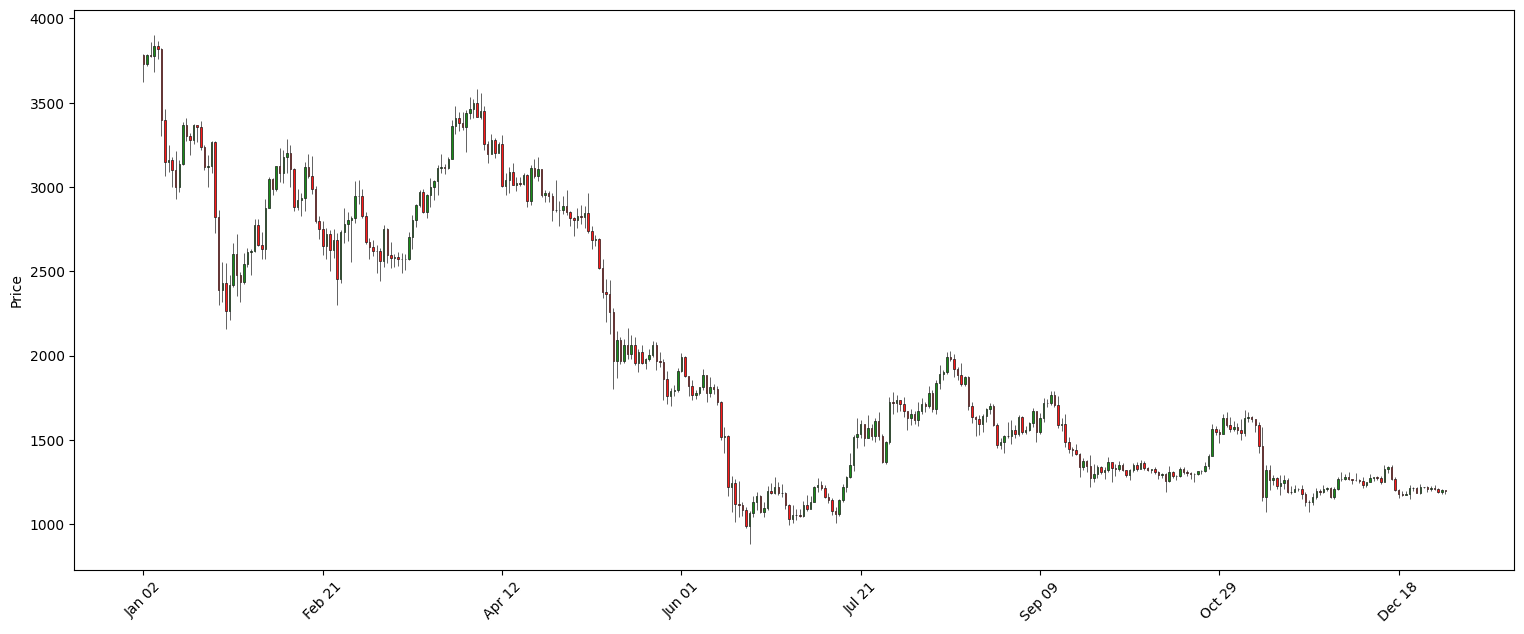

In [7]:
mcWeek = mpf.make_marketcolors(up='g',down='r')
sWeek = mpf.make_mpf_style(marketcolors=mcWeek)
mpf.plot(dataCoin.loc[weekStartDay:], type='candle',style=sWeek, figsize=(20,8), tight_layout=False) 

In [2]:
collectionBreadth = client['multiSymbolsFactor']['UpdownPercentUni1H']
data_breadth = pd.DataFrame(
    list(collectionBreadth.find({"datetime": {'$gt': startTime, '$lt': endTime}}))
)
dataBreadth = data_breadth.set_index('datetime')

In [3]:
dataBreadth.tail()

,_id,udp480,udp720,udp960,udp1200,udp1440,udp1680,udp1920,udp2160,udp2400,symbols
datetime,,,,,,,,,,,
2022-08-12 05:00:00,62f9ddf827d65096fec94687,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,0.666667,"btc,eth,uni,link,matic,axs"
2022-08-12 06:00:00,62f9ddf827d65096fec9468a,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,0.666667,"btc,eth,uni,link,matic,axs"
2022-08-12 07:00:00,62f9ddf827d65096fec9468d,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,0.666667,"btc,eth,uni,link,matic,axs"
2022-08-12 08:00:00,62f9ddf827d65096fec94690,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,0.666667,"btc,eth,uni,link,matic,axs"
2022-08-12 09:00:00,62f9ddf827d65096fec94693,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,0.666667,"btc,eth,uni,link,matic,axs"


In [4]:
dataCoin['close']

datetime
2021-05-01 01:00:00    2770.12
2021-05-01 02:00:00    2757.59
2021-05-01 03:00:00    2777.12
2021-05-01 04:00:00    2783.50
2021-05-01 05:00:00    2764.60
                        ...   
2022-08-12 06:00:00    1900.36
2022-08-12 07:00:00    1873.71
2022-08-12 08:00:00    1881.53
2022-08-12 09:00:00    1884.90
2022-08-12 10:00:00    1880.30
Name: close, Length: 11237, dtype: float64

In [5]:
dataCoin['udp960'] = dataBreadth['udp960']
dataCoin['pctChange'] = dataCoin['close'].pct_change()
dataCoin['pctStd'] = ta.STDDEV(dataCoin['pctChange'], 24*5)*(24**0.5)

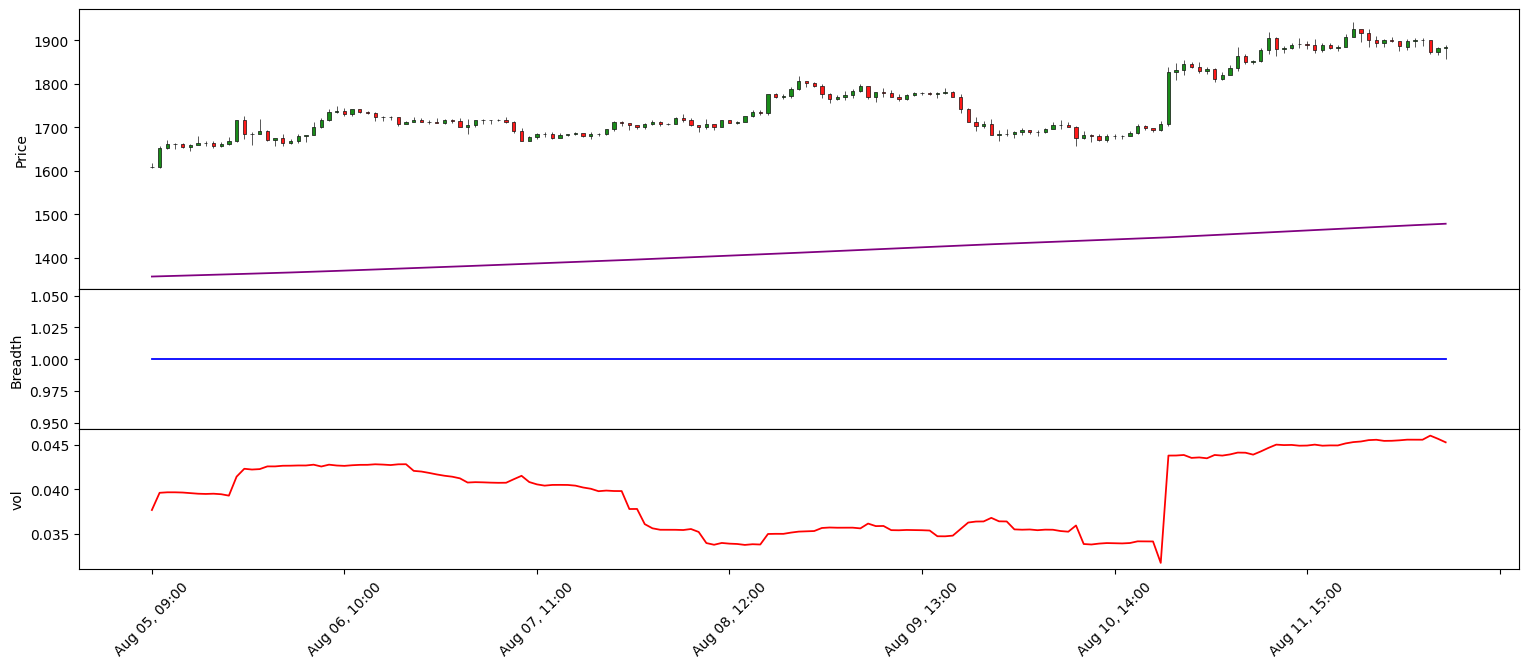

In [7]:
apdictWeek = [
         mpf.make_addplot(ta.MA(dataCoin['close'], 38*24).loc[weekStartDay:weekStartDay+timedelta(days=7)],color='purple', ylabel='MA50'),
         mpf.make_addplot(dataCoin['udp960'].loc[weekStartDay:weekStartDay+timedelta(days=7)], color='blue', panel=1,ylabel='Breadth'),
         mpf.make_addplot(dataCoin['pctStd'].loc[weekStartDay:weekStartDay+timedelta(days=7)],color='red', panel=2,ylabel='vol')
         ]
mcWeek = mpf.make_marketcolors(up='g',down='r')
sWeek = mpf.make_mpf_style(marketcolors=mcWeek)    

mpf.plot(dataCoin.loc[weekStartDay:weekStartDay+timedelta(days=7)], type='candle',style=sWeek, figsize=(20,8), addplot=apdictWeek,panel_ratios=(4,2,2),tight_layout=False) 

In [8]:
# dataCoin

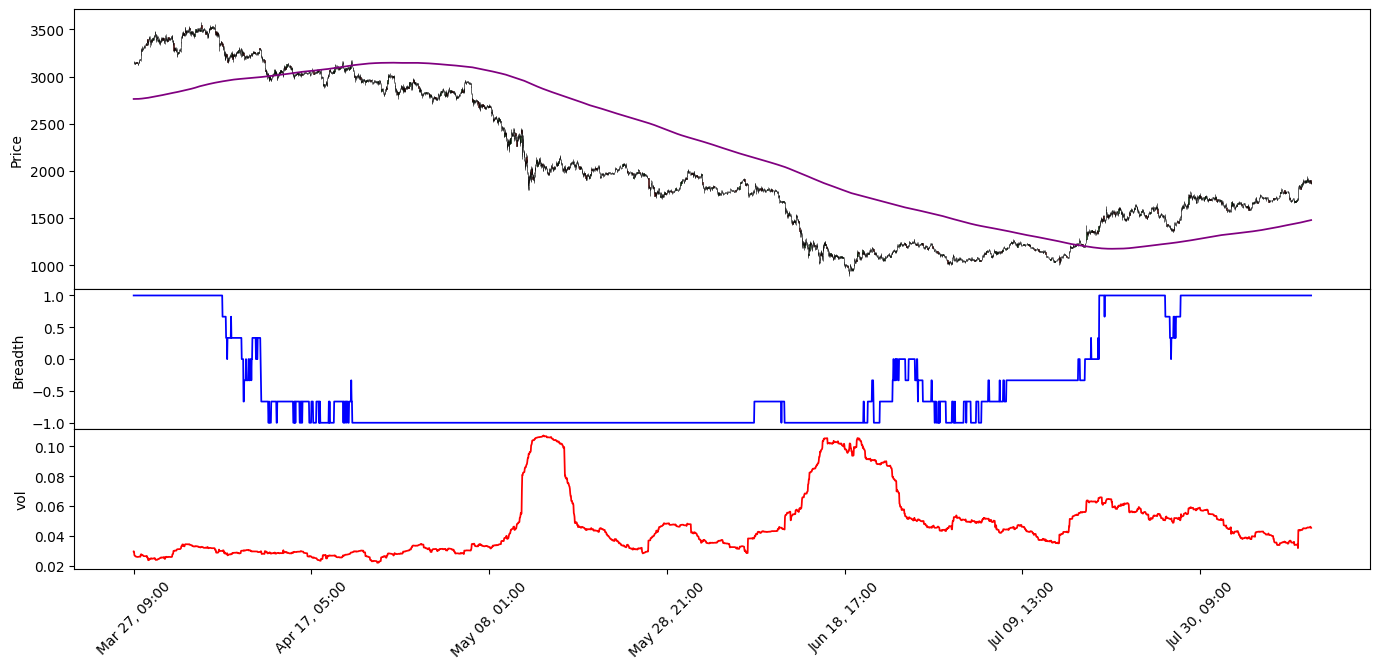

In [9]:
startDate = datetime(2022,3,27,9)
apdict = [
         mpf.make_addplot(ta.MA(dataCoin['close'], 38*24).loc[startDate:weekStartDay+timedelta(days=7)],color='purple', ylabel='MA50'),
         mpf.make_addplot(dataCoin['udp960'].loc[startDate:weekStartDay+timedelta(days=7)], color='blue', panel=1,ylabel='Breadth'),
         mpf.make_addplot(dataCoin['pctStd'].loc[startDate:weekStartDay+timedelta(days=7)],color='red', panel=2,ylabel='vol')
         ]
mc = mpf.make_marketcolors(up='g',down='r')
s = mpf.make_mpf_style(marketcolors=mc)
# mpf.plot(dataCoin, type='candle',style=s,figsize=(18,8),addplot=apdict,panel_ratios=(3,2,2),tight_layout=True,ylim=(3200,4300)) 
mpf.plot(dataCoin.loc[startDate:weekStartDay+timedelta(days=7)], type='candle',style=s, figsize=(18,8), addplot=apdict,panel_ratios=(4,2,2),tight_layout=False) 

In [11]:
dataCoin.tail()

,open,high,low,close,volume,udp960,pctChange,pctStd
datetime,,,,,,,,
2022-08-12 06:00:00,1900.03,1905.38,1886.70,1900.36,16084.8906,1.0,0.000168,0.045594
2022-08-12 07:00:00,1900.36,1900.50,1868.29,1873.71,31262.4416,1.0,-0.014024,0.046056
2022-08-12 08:00:00,1873.70,1883.73,1867.27,1881.53,23752.0688,1.0,0.004174,0.045697
2022-08-12 09:00:00,1881.54,1889.98,1857.67,1884.90,33923.0831,1.0,0.001791,0.045301
2022-08-12 10:00:00,1884.89,1891.91,1878.00,1880.30,14687.4655,NaN,-0.002440,0.045304


In [12]:
symbolsCloseDict = {}
for symbol in symbolsList:
    collection = client['Kline_1Min_Auto_Db_Plus'][symbol]
    dataCoin = prepareData(collection, startTime, endTime, rsPeriod)
    symbolsCloseDict[symbol] = dataCoin['close']
symbolsCloseDf = pd.DataFrame(symbolsCloseDict)
symbolsCloseDfWeek = symbolsCloseDf.loc[weekStartDay:weekStartDay+timedelta(days=7)]

In [13]:
import seaborn as sns

def corr_chart(closeDf):
    corrDf = closeDf.pct_change().corr()
    mask = np.zeros_like(corrDf)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i] = 0
    plt.figure(figsize=(6,6))
    with sns.axes_style("white"):
        ax = sns.heatmap(corrDf, mask=mask,square=True,annot=True,cmap="YlGnBu")
    eth_avg_corr = ((corrDf.sum()-1)/5)['eth_usdt.spot:binance']
    eth_avg_corr = round(eth_avg_corr,2)
    plt.text(-1,-1,f'The [{closeDf.index[0]}] to [{closeDf.index[-1]}]\'s Return Array Average Correlation')
    plt.text(-1,-0.6,f'between ETH and others is : {eth_avg_corr}')
    plt.show()

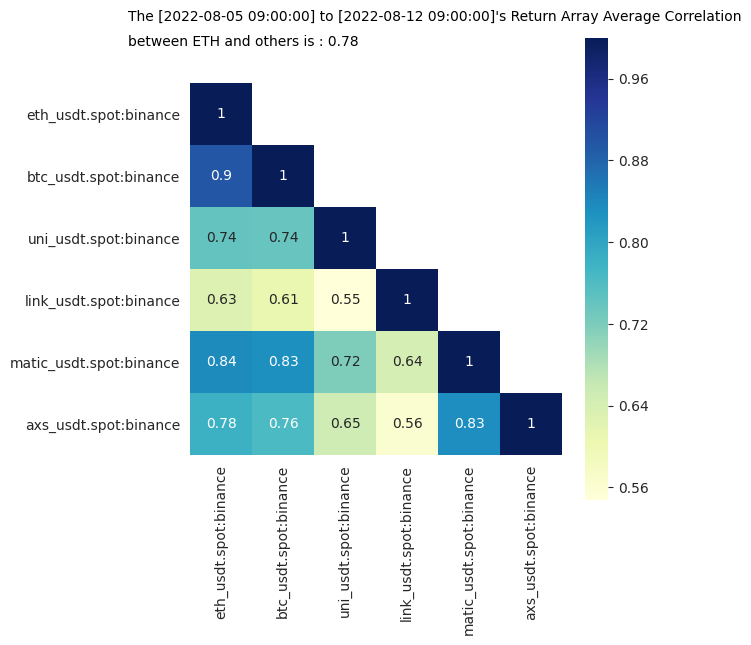

In [14]:
corr_chart(symbolsCloseDfWeek)

In [15]:
symbolsCloseDfWeek

,eth_usdt.spot:binance,btc_usdt.spot:binance,uni_usdt.spot:binance,link_usdt.spot:binance,matic_usdt.spot:binance,axs_usdt.spot:binance
datetime,,,,,,
2022-08-05 09:00:00,1608.75,22646.50,8.81,7.375,0.8901,17.63
2022-08-05 10:00:00,1653.24,22906.68,8.97,7.491,0.9085,17.96
2022-08-05 11:00:00,1661.28,23050.93,9.04,7.573,0.9144,17.97
2022-08-05 12:00:00,1661.50,23182.85,9.11,7.649,0.9242,18.17
2022-08-05 13:00:00,1655.62,23153.44,9.14,7.694,0.9209,18.16
...,...,...,...,...,...,...
2022-08-12 05:00:00,1900.04,24198.42,9.04,9.138,0.9273,18.64
2022-08-12 06:00:00,1900.36,24205.69,9.03,9.057,0.9264,18.57
2022-08-12 07:00:00,1873.71,23933.84,8.92,8.976,0.9201,18.43


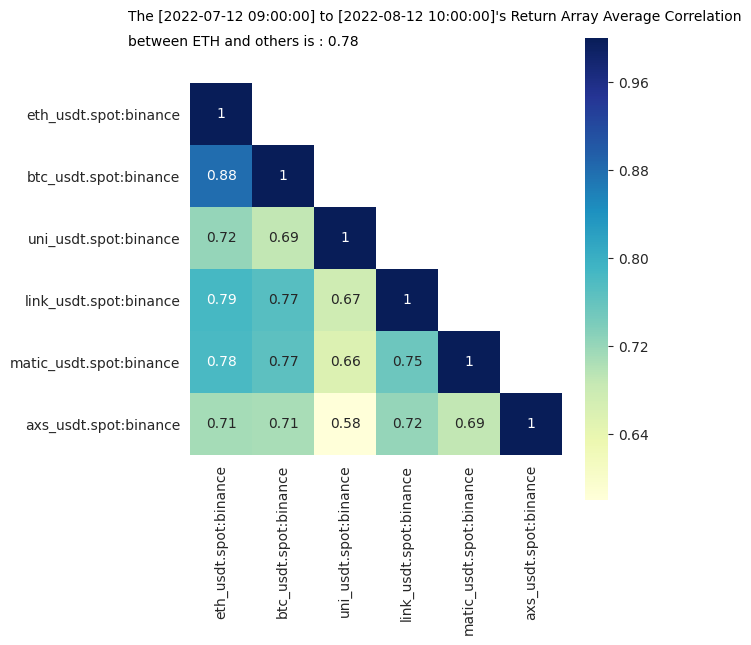

In [16]:
corr_chart(symbolsCloseDf.loc[datetime(2022,7,12,9):datetime(2022,8,12,10)])

In [27]:
aDict = {"1234": 1234}

In [28]:
a= aDict.keys()

In [29]:
for k, v in aDict.items():
    print(k, v)

1234 1234


In [30]:
datetime.fromtimestamp(1652434260)

datetime.datetime(2022, 5, 13, 17, 31)